## Importaciones

In [2]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager

## Cargar Dataset

In [3]:
csv_file = "../Data/cityA_groundtruthdata.csv/cityA_groundtruthdata.csv"
manager = DataManager(
    csv_path=csv_file,
)
df = manager.load_csv()

print("Dataset creado:")

# Ver las dimensiones del DataFrame (filas y columnas)
print(f"Dimensiones del DataFrame: {df.shape}")

# Ver los nombres de las columnas y sus tipos de datos
print("\nInformación del DataFrame:")
display(df.info())  # display() para mejor presentación en notebooks

# Mostrar las primeras filas del DataFrame
print("\nPrimeras 5 filas del DataFrame:")
display(df.head(75))  # Mejor presentación en notebook

# Verificar si hay valores nulos por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Resumen estadístico de los datos numéricos
print("\nResumen estadístico:")
display(df.describe())

top_users = df["uid"].value_counts().head(10)
print("Usuarios más activos:\n", top_users)

Dataset creado:
Dimensiones del DataFrame: (111535175, 5)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111535175 entries, 0 to 111535174
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 4.2 GB


None


Primeras 5 filas del DataFrame:


,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89
...,...,...,...,...,...
70,0,3,38,76,83
71,0,3,39,76,84
72,0,3,40,77,86
73,0,3,46,79,87



Valores nulos por columna:
uid    0
d      0
t      0
x      0
y      0
dtype: int64

Resumen estadístico:


,uid,d,t,x,y
count,1.115352e+08,1.115352e+08,1.115352e+08,1.115352e+08,1.115352e+08
mean,4.917461e+04,3.740868e+01,2.596529e+01,1.229079e+02,8.565036e+01
std,2.881183e+04,2.168145e+01,1.116733e+01,4.209912e+01,4.281913e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,2.393200e+04,1.900000e+01,1.800000e+01,9.500000e+01,5.800000e+01
50%,4.925800e+04,3.800000e+01,2.600000e+01,1.270000e+02,8.400000e+01
75%,7.392900e+04,5.700000e+01,3.500000e+01,1.550000e+02,1.110000e+02
max,9.999900e+04,7.400000e+01,4.700000e+01,2.000000e+02,2.000000e+02


Usuarios más activos:
 uid
62023    3497
63991    3456
62164    3431
63726    3367
2716     3358
2041     3335
56979    3333
963      3302
63484    3295
67216    3285
Name: count, dtype: int64


In [4]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


## Preprocesamiento y Creación de Secuencias

In [5]:
scaler = MinMaxScaler()
numerical_cols = ["d", "t", "x", "y"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


# Crear secuencias de 7 días
def create_week_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(0, len(data) - 2 * seq_length, seq_length):
        X.append(data[i : i + seq_length])  # Semana de entrada
        y.append(
            data[i + seq_length : i + 2 * seq_length]
        )  # Semana siguiente (objetivo)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


seq_length = 7  # Ventana de 7 días
X, y = create_week_sequences(df[numerical_cols].values, seq_length)


# Dataset y DataLoader
class WeekDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = WeekDataset(X, y)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

print(f"Datos preparados: {len(dataset)} muestras")

C:\Users\Brian_iq\AppData\Local\Temp\ipykernel_4868\2402090192.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Datos preparados: 15933595 muestras


## Modelos


In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=4, seq_length=7):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_length * input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, seq_length * output_size),
        )

        self.seq_length = seq_length
        self.output_size = output_size

    def forward(self, x):
        out = self.model(x)
        return out.view(
            -1, self.seq_length, self.output_size
        )  # Salida con forma (batch_size, 7, 4)

## Función de Entrenamiento

In [7]:
def train_model(model, dataloader, epochs=100, lr=0.001):
    """
    Función para entrenar el modelo.

    Args:
        model: Instancia del modelo a entrenar.
        dataloader: DataLoader con los datos de entrenamiento.
        epochs (int): Número de épocas.
        lr (float): Tasa de aprendizaje.

    Returns:
        losses (list): Lista con las pérdidas de cada época.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []  # Almacena las pérdidas por época

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()  # Reiniciar gradientes
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Calcular pérdida
            loss.backward()  # Retropropagación
            optimizer.step()  # Actualizar pesos
            total_loss += loss.item()

        # Pérdida promedio por época
        epoch_loss = total_loss / len(dataloader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    return losses

## Entrenamiento y Gráficas Comparativas

Epoch [1/10], Loss: 0.0135
Epoch [2/10], Loss: 0.0132
Epoch [3/10], Loss: 0.0131
Epoch [4/10], Loss: 0.0131
Epoch [5/10], Loss: 0.0131
Epoch [6/10], Loss: 0.0130
Epoch [7/10], Loss: 0.0130
Epoch [8/10], Loss: 0.0130
Epoch [9/10], Loss: 0.0130
Epoch [10/10], Loss: 0.0130


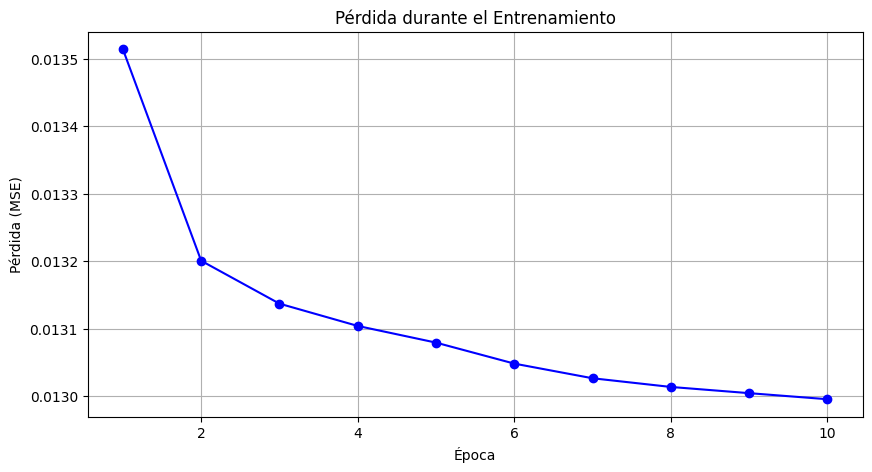

In [ ]:
model = SimpleNN(hidden_size=256)

# Entrenar el modelo
epochs = 10
losses = train_model(model, dataloader, epochs=epochs, lr=0.001)

# Graficar la pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, marker="o", linestyle="-", color="b")
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.grid()
plt.show()

In [9]:
torch.save(model, "../Data/Models/simple_nn_complete.pth")
print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.


## Visualización de predicciones

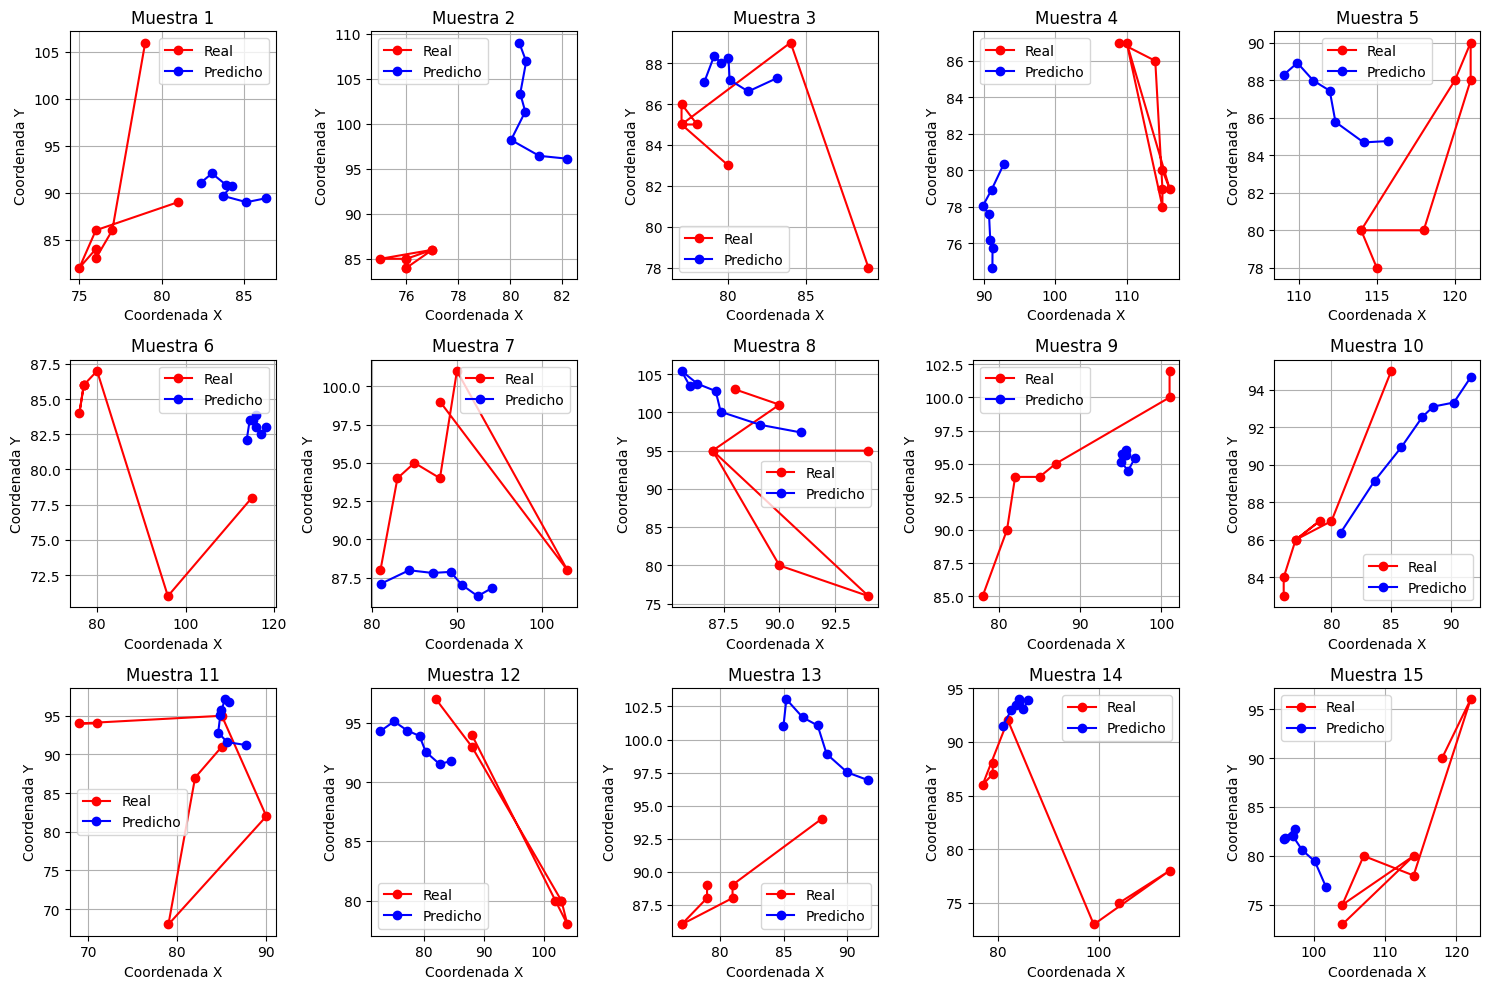

In [12]:
# Configuración del modelo en modo evaluación
model.eval()

# Número de muestras a graficar
num_samples = 15  # Número de predicciones a visualizar
num_columns = 5  # Número de columnas en la gráfica
num_rows = (num_samples + num_columns - 1) // num_columns  # Filas necesarias

# Crear subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
axes = axes.flatten()  # Aplanar para acceder a los ejes más fácilmente

# Iterar sobre las primeras 'num_samples' muestras del dataset
with torch.no_grad():
    for idx in range(num_samples):
        # Obtener los datos de entrada y salida reales
        sample_X, sample_y = dataset[idx]
        predicted = model(sample_X.unsqueeze(0).to(torch.float32)).squeeze(
            0
        )  # Predicción

        # Desnormalizar los datos
        sample_y = scaler.inverse_transform(sample_y)
        predicted = scaler.inverse_transform(predicted)

        # Graficar en cada subplot
        axes[idx].plot(
            sample_y[:, 2], sample_y[:, 3], "ro-", label="Real"
        )  # Coordenadas reales
        axes[idx].plot(
            predicted[:, 2], predicted[:, 3], "bo-", label="Predicho"
        )  # Predicciones
        axes[idx].set_title(f"Muestra {idx+1}")
        axes[idx].set_xlabel("Coordenada X")
        axes[idx].set_ylabel("Coordenada Y")
        axes[idx].grid(True)
        axes[idx].legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()